In [15]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import re
import math
import os
from tensorflow.keras import layers as L

train_file = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/*.tfrec')
val_file = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/*.tfrec')
test_file = tf.io.gfile.glob('/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192/train/*.tfrec')

#Settings
#path = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192"
image_size = (192, 192)
classes = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
           'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
           'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion',
           'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy',
           'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
           'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
           'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose']
features = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64)
}
n_classes = 104

#Run processes in parallel
auto = tf.data.AUTOTUNE
BATCH_SIZE = 16
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-4
EPOCHS = 30
LEARNING_RATE = 3e-5
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 104
ES_PATIENCE = 5
model_path = f'model_{HEIGHT}x{WIDTH}.h5'

In [4]:
#Connect to TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

#Set batch size (4x the number of cores used, 8 is used in Kaggle)
batch_size = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-11 09:19:49.423813: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.423916: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.424014: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.424124: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.424222: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.424435: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:19:49.424531: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [192, 192, 3])
    return image

def read_labeled_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames)  
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord)
    return dataset

def get_dataset(filenames, batch_size=16, shuffle_buffer_size=10000):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.prefetch(buffer_size=auto)
    dataset = dataset.batch(batch_size)
    return dataset

train = get_dataset(train_file, batch_size=batch_size)
val = get_dataset(val_file, batch_size=batch_size)
test = get_dataset(test_file, batch_size=batch_size)

In [6]:
MAX_LR = 0.00005

def exponential_lr(epoch,
                   start_lr=0.00001, min_lr=0.00001, max_lr=MAX_LR,
                   rampup_epochs=5, sustain_epochs=2,
                   exp_decay=0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

In [16]:
def create_model_cnn(input_shape, n_classes):
    # CNN Model (example with simple convolutional layers)
    model = tf.keras.Sequential([
        L.Conv2D(64, (3, 3), input_shape=input_shape, activation='relu'),
        L.MaxPooling2D((2, 2)),
        L.Conv2D(128, (3, 3), activation='relu'),
        L.GlobalAveragePooling2D(),
        L.Dense(N_CLASSES, activation='softmax')
     ])
    return model

In [17]:
def create_model_fnn(input_shape, n_classes):
    model = tf.keras.Sequential([
        L.Flatten(input_shape=input_shape),
        L.Dense(512, activation='relu'),
        L.Dense(256, activation='relu'),
        L.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [19]:
with strategy.scope():
    model = create_model_cnn((None, None, 3), 3)

metric_list = ['sparse_categorical_accuracy']
optimizer = tf.keras.optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=metric_list)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, None, None, 64)    1792      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 64)    0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 global_average_pooling2d_1  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 104)               13416     
                                                                 
Total params: 89064 (347.91 KB)
Trainable params: 8906

In [24]:
history = model.fit(
    x=train,
    steps_per_epoch=50,
    validation_data=val,
    callbacks=lr_callback,
    epochs=EPOCHS,
    verbose=2
).history


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30


2023-12-11 09:27:29.543592: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.561639: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.579921: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.599671: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.617364: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.634850: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:29.652130: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

50/50 - 21s - loss: 4.5845 - sparse_categorical_accuracy: 0.0480 - val_loss: 4.4964 - val_sparse_categorical_accuracy: 0.0613 - lr: 1.0000e-04 - 21s/epoch - 418ms/step

Epoch 2: LearningRateScheduler setting learning rate to 8.999999797903001e-05.
Epoch 2/30


2023-12-11 09:27:52.099699: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:52.099943: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 09:27:53.981729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


50/50 - 8s - loss: 4.3894 - sparse_categorical_accuracy: 0.0586 - val_loss: 4.2774 - val_sparse_categorical_accuracy: 0.0616 - lr: 9.0000e-05 - 8s/epoch - 156ms/step

Epoch 3: LearningRateScheduler setting learning rate to 7.400000081863255e-05.
Epoch 3/30


2023-12-11 09:28:00.283059: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


50/50 - 6s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.2774 - val_sparse_categorical_accuracy: 0.0616 - lr: 7.4000e-05 - 6s/epoch - 110ms/step


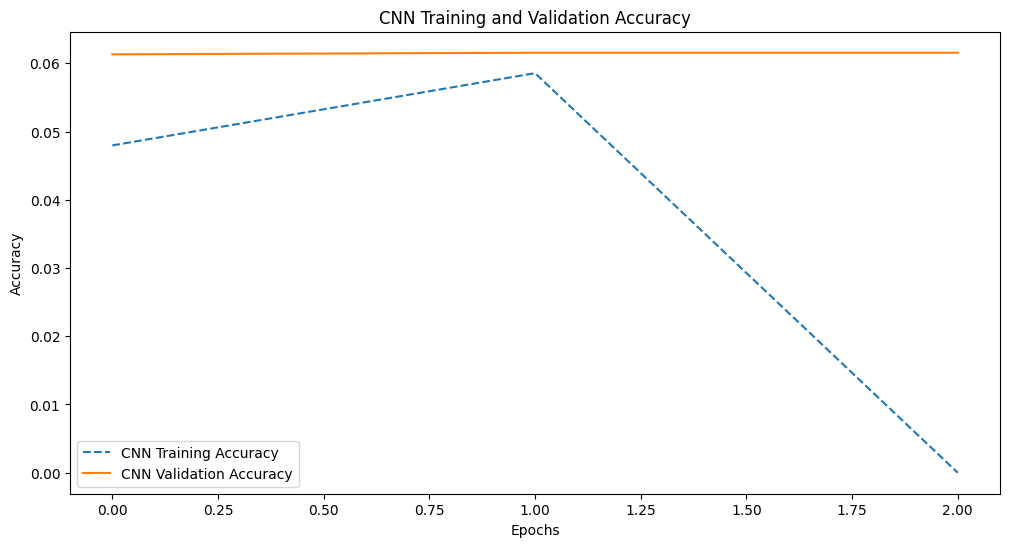

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history['sparse_categorical_accuracy'], label='CNN Training Accuracy', linestyle='dashed')
plt.plot(history['val_sparse_categorical_accuracy'], label='CNN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.show()